In [105]:
import numpy as np
import librosa.display, os
import matplotlib.pyplot as plt
import tensorflow as tf
import time

from sklearn.model_selection import train_test_split
from keras import models
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
%matplotlib inline

In [150]:
def resample_audio(signal, sr, sampled_sr= 44100):
        if sr != sampled_sr:
            signal_resampled = librosa.resample(signal, orig_sr=sr, target_sr=sampled_sr)
            return signal_resampled, sampled_sr
        return signal, sr

def process_audio_duration(signal, sr, target_duration=5.0):
    # Make sure all audio are 5s
    target_samples = int(target_duration * sr)
    current_samples = len(signal)
    
    if current_samples > target_samples:
        signal = signal[:target_samples]
    
    # If the audio is shorter, pad with zeros (silence) to the target duration
    elif current_samples < target_samples:
        pad_length = target_samples - current_samples
        signal = np.pad(y, (0, pad_length), mode='constant')
    
    return signal, sr

def melspec_normalization(log_ms):
    # Normalize to [0, 1]
    return (log_ms - log_ms.min()) / (log_ms.max() - log_ms.min())
    
def load_audio(audio_file):
    y, sr = librosa.load(audio_file)
    y, sr = resample_audio(y, sr)
    # TO DO: should we add this?  reduce accuracy but looks better to compare spectrogram
    #y, sr = process_audio_duration(y,sr)
    y = librosa.util.normalize(y)
    return y,sr
    
def create_mel_spectrogram(audio_file):
    """
    :param audio_file:string 
    Creating Mel Spectogram from Audio File
    """

    y, sr = load_audio(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    log_ms = melspec_normalization(log_ms)
    return log_ms, sr


def create_mel_spectrogram_image(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    log_ms, sr = create_mel_spectrogram(audio_file)

    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)

    
def create_pngs_from_wavs(input_path:str, output_path:str):
    """
    :param input_path: string
    :param output_path: string
    """

    #checking if the folder exists
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    #creating Mel Spectgorams from input folder to output folder
    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_mel_spectrogram_image(input_file, output_file)


/opt/anaconda3/envs/dl_course/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)
/opt/anaconda3/envs/dl_course/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  return f(*args, **kwargs)


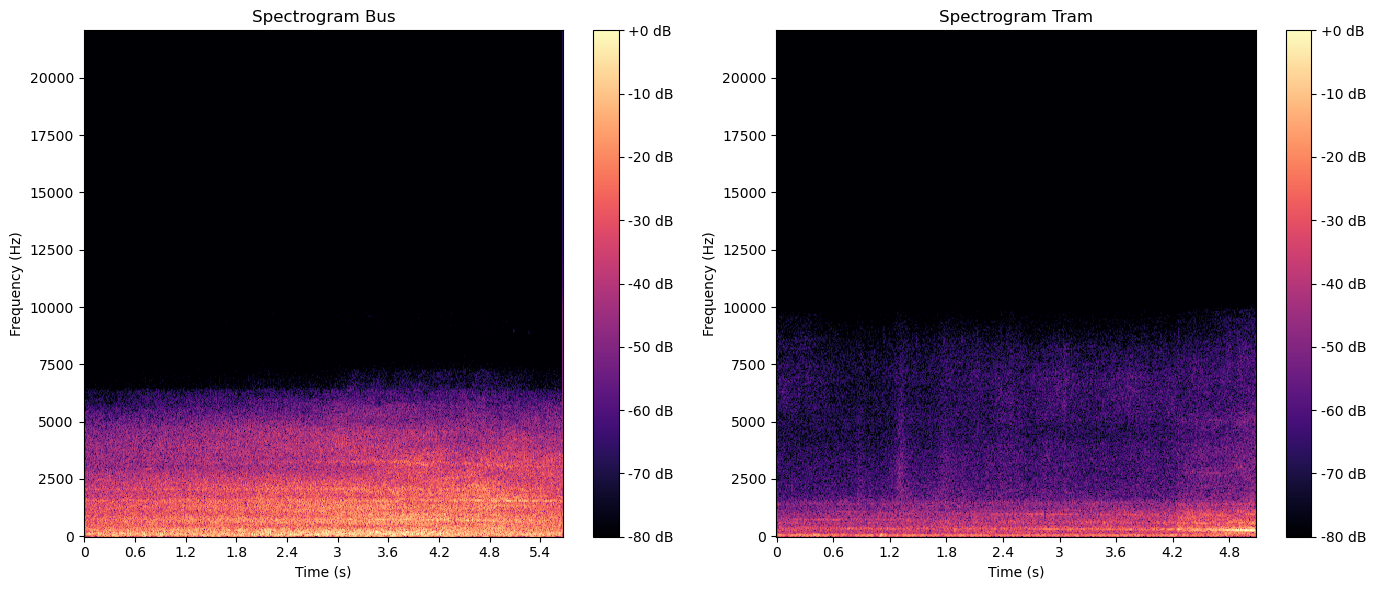

In [151]:
# Plot some spectrogram and compare
def create_spectrogram(audio_file):
    y, sr = load_audio(audio_file)
    n_fft = 1024
    win_length = n_fft
    hop_length = n_fft//2
    librosa_spectrogram = librosa.stft(y=y,n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    librosa_power_spectrogram = librosa.amplitude_to_db(librosa_spectrogram, ref=np.max)
    return librosa_power_spectrogram, sr


librosa_power_spectrogram1,sr1 = create_spectrogram('./dataset/bus/657981__petrijuhani__bussi2.wav')
librosa_power_spectrogram2,sr2 = create_spectrogram('./dataset/tram/709545__masa_ite__tram_hervannan_kampus_b_2.wav')

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
librosa.display.specshow(librosa_power_spectrogram1, sr=sr1, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Bus')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.subplot(1, 2, 2)
librosa.display.specshow(librosa_power_spectrogram2, sr=sr2, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram Tram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

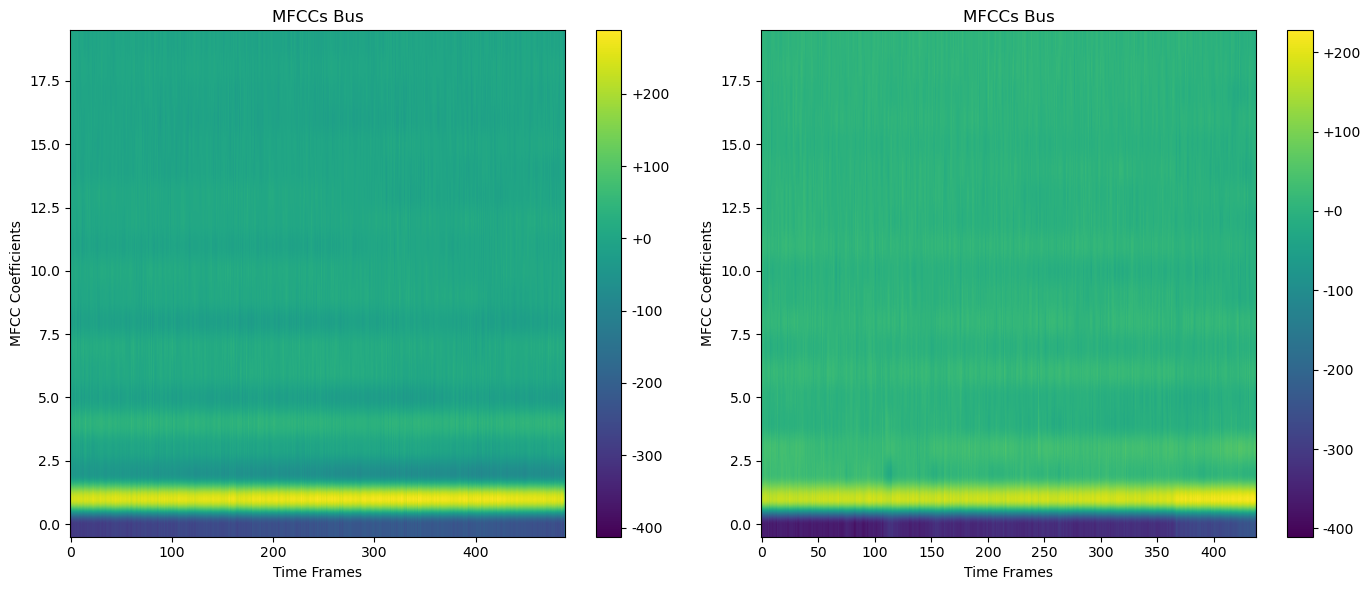

In [152]:
#Plot some mfccs and compare
def create_mfcc(audio_file):
    y, sr = load_audio(audio_file)
    n_fft = 1024
    hop_length =n_fft//2 
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    return mfccs

mfccs1 = create_mfcc('./dataset/bus/657981__petrijuhani__bussi2.wav')
mfccs2 = create_mfcc('./dataset/tram/709545__masa_ite__tram_hervannan_kampus_b_2.wav')


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(mfccs1, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f')
plt.title("MFCCs Bus")
plt.xlabel("Time Frames")
plt.ylabel("MFCC Coefficients")

plt.subplot(1, 2, 2)
plt.imshow(mfccs2, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f')
plt.title("MFCCs Bus")
plt.xlabel("Time Frames")
plt.ylabel("MFCC Coefficients")

plt.tight_layout()
plt.show()

In [ ]:
create_pngs_from_wavs('./dataset/bus', './Spectogram_images/bus')
create_pngs_from_wavs('./dataset/tram', './Spectogram_images/tram')


In [ ]:
def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        images.append(tf.keras.utils.img_to_array(tf.keras.utils.load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        labels.append((label))
        
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

        
x = []
y = []

In [ ]:
images, labels = load_images_from_path('./Spectogram_images/bus', 0)
x += images
y += labels

show_images(images)

In [ ]:
images, labels = load_images_from_path('./Spectogram_images/tram', 1)
x += images
y += labels

show_images(images)

In [ ]:
print(f'x size: {len(x)}')
print(f'y size: {len(y)}')

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=0)

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train_encoded =  tf.keras.utils.to_categorical(y_train)
y_test_encoded =  tf.keras.utils.to_categorical(y_test)

In [ ]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
print(f'x_train_norm: {x_train_norm.shape}')
print(f'x_test_norm: {x_test_norm.shape}')

print(f'y_train_encoded: {y_train_encoded.shape}')
print(f'y_test_encoded: {y_test_encoded.shape}')

start_time = time.time()
hist = model.fit(x_train_norm, y_train_encoded, validation_data=(x_test_norm, y_test_encoded), batch_size=10, epochs=10)
end_time = time.time()

total_time = end_time - start_time
print(f"Total Training Time: {total_time:.2f} seconds")

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
loss = hist.history['loss']

plt.plot(epochs, loss, '--', label='Loss')
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower left')
plt.plot()

In [ ]:
model.save('vehicle-audio-processing-model.keras')

In [ ]:
create_pngs_from_wavs('./test_audio', './Spectogram_images/test')


In [ ]:
x = tf.keras.utils.load_img('./Spectogram_images/test/664055__juusooo__bus-2.png', target_size=(224, 224))

plt.xticks([])
plt.yticks([])
plt.imshow(x)

In [ ]:
x = tf.keras.utils.img_to_array(x)
x = np.expand_dims(x, axis=0)

predictions = model.predict(x)
class_labels = ['bus', 'tram']

for i, label in enumerate(class_labels):
    print(f'{label}: {predictions[0][i]}')